In [69]:
%load_ext tensorboard
%matplotlib inline

import os 
import math
import datetime
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from tensorflow import keras as kr
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.datasets import mnist 
(X_train_orig, Y_train_orig), (X_test_orig, Y_test_orig) = mnist.load_data()

!rm -rf ./logs/

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [18]:
print('MNIST Dataset Shape:')
batch_size = 64 
buffer_size = 10000
steps_per_epoch = int(np.ceil(60000) / float(batch_size))
epochs = 10
num_classes = 10

X_train = X_train_orig.astype(np.float32)/255
X_train = np.expand_dims(X_train, -1)
X_test = X_test_orig.astype(np.float32)/255
X_test = np.expand_dims(X_test, -1)
Y_train = tf.one_hot(Y_train_orig, num_classes)
Y_test = tf.one_hot(Y_test_orig, num_classes)

print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(Y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(Y_test.shape))

MNIST Dataset Shape:
X_train: (60000, 28, 28, 1)
Y_train: (60000, 10)
X_test:  (10000, 28, 28, 1)
Y_test:  (10000, 10)


In [19]:
def Conv_Model(inputs):
    X_input = kr.Input(inputs)
    X = layers.Conv2D(32, (3,3), activation = 'relu', padding = 'valid')(X_input)
    X = layers.MaxPooling2D(pool_size=(2,2))(X)
    X = layers.Conv2D(64, (3,3), activation = 'relu')(X)
    X = layers.MaxPooling2D(pool_size=(2,2))(X)
    X = layers.Flatten()(X)
    X = layers.Dense(512, activation = 'relu')(X)
    X = layers.Dropout(0.5)(X)
    X = layers.Dense(num_classes, activation='softmax', name = 'X_preds')(X)

    model = kr.models.Model(inputs = X_input, outputs = X, 
            name = "Mnist_Conv_Model")

    return model

In [20]:
Conv_Model = Conv_Model(X_train.shape[1:])
Conv_Model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ["accuracy"])

In [21]:
Conv_Model.fit(x = X_train, y = Y_train, epochs = 5, batch_size = 64, callbacks=[tensorboard_callback])

Epoch 1/5
938/938 [==============================] - 20s 22ms/step - loss: 0.1628 - accuracy: 0.9492
Epoch 2/5
938/938 [==============================] - 21s 23ms/step - loss: 0.0511 - accuracy: 0.9847
Epoch 3/5
938/938 [==============================] - 24s 26ms/step - loss: 0.0373 - accuracy: 0.9883
Epoch 4/5
938/938 [==============================] - 29s 31ms/step - loss: 0.0302 - accuracy: 0.9911
Epoch 5/5
938/938 [==============================] - 23s 24ms/step - loss: 0.0235 - accuracy: 0.9926


In [16]:
Conv_Model.save('mnist_cnn.h5')

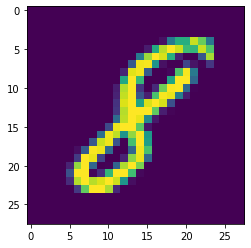

In [66]:
example = X_train[7777].reshape(28,28)
plt.imshow(example)

In [98]:
layer_outs = [layer.output for layer in Conv_Model.layers[1:5]]
activation_model = kr.models.Model(inputs=Conv_Model.input, outputs=layer_outs)

In [99]:
img_tensor = X_train[7777].reshape(1, 28, 28, 1)
activations = activation_model.predict(img_tensor)
for activation in activations:
    print(activation.shape)

(1, 26, 26, 32)
(1, 13, 13, 32)
(1, 11, 11, 64)
(1, 5, 5, 64)


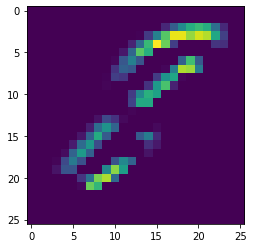

In [100]:
plt.imshow(first_layer_activation[0,:,:,0], cmap= 'viridis')

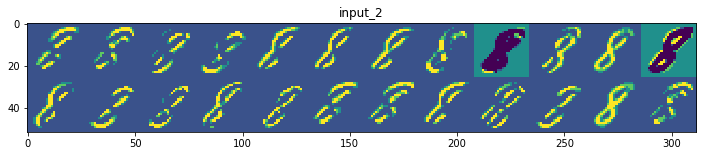

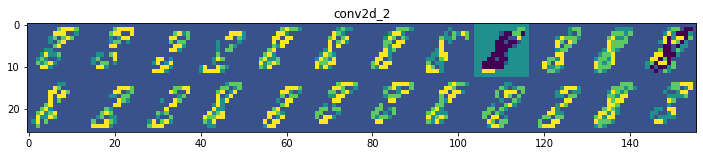

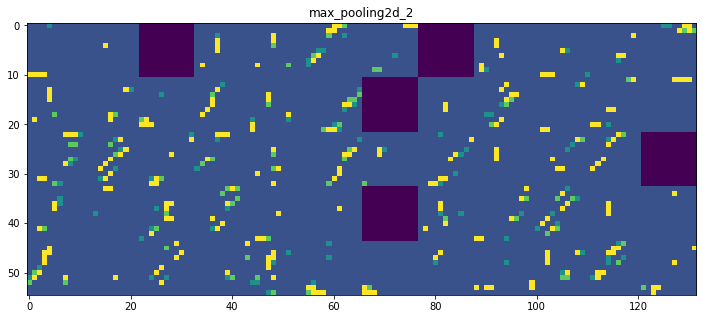

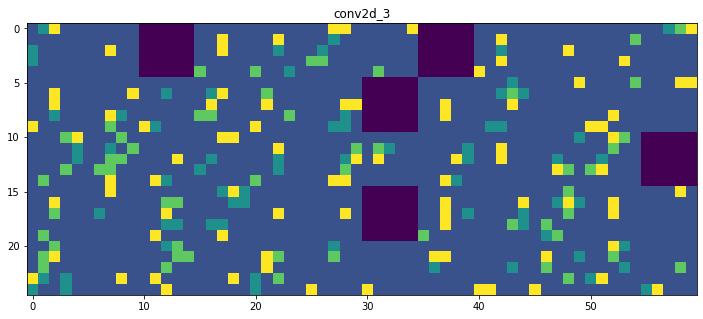

In [101]:
layer_names = []
for layer in Conv_Model.layers[:8]:
    layer_names.append(layer.name)

img_per_row = 12

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // img_per_row
    display_grid = np.zeros((size * n_cols, img_per_row * size))
    for col in range(n_cols):
        for row in range(img_per_row):
            channel_image = layer_activation[0,:,:,col * img_per_row + row]
            channel_image = (channel_image-channel_image.mean())//channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')